In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Import

In [2]:
import copy

from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary
from transformers import ViTModel, AutoImageProcessor, BertModel, AutoTokenizer

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

# from architecture import Transformer
# from architecture_detail import *

import cv2

device = torch.device("cuda")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [3]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 100
PRED_LEN = 100

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day",  "dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
patch_size = 14

d_model = {"encoder":128, "decoder":64}
d_ff = {"encoder":128, "decoder":64}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"target":0.25, "temporal":0.25, "img":0.25, "nlp":0.25}

# Data

### Raw data

In [4]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [5]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_train = df_train[~pd.isna(df_train["detail_desc"])]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]
df_valid = df_valid[~pd.isna(df_valid["detail_desc"])]

data_info = DataInfo(modality_info, processing_info)

In [6]:
import urllib3, socket
from urllib3.connection import HTTPConnection

HTTPConnection.default_socket_options = ( 
    HTTPConnection.default_socket_options + [
    (socket.SOL_SOCKET, socket.SO_SNDBUF, 2000000), 
    (socket.SOL_SOCKET, socket.SO_RCVBUF, 2000000)
    ])

In [7]:
train_dataset = Dataset(df_train, data_info, remain_rto)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:00<00:00, 29806.86it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([32, 100, 1])
day torch.Size([32, 100])
dow torch.Size([32, 100])
month torch.Size([32, 100])
holiday torch.Size([32, 100])
price torch.Size([32, 100, 1])
target_fcst_mask torch.Size([32, 100, 1])
temporal_padding_mask torch.Size([32, 100])
img_path torch.Size([32, 3, 224, 224])


# Architecture

In [8]:
import math
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        input = [batch, seq_len, d_model]
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = torch.permute(x, (1,0,2))
        x = x + self.pe[:x.size(0)]
        x = torch.permute(x, (1,0,2))
        return self.dropout(x)

class MultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        self.nhead = nhead

        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.output_linear = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query_dict, key_dict, value_dict, key_padding_mask_dict):
        attn_output_dict, attn_weight_dict = {}, {}
        query_temporal = True if "temporal" in query_dict.keys() else False
        query_static = True if "static" in query_dict.keys() else False

        key_temporal = True if "temporal" in key_dict.keys() else False
        key_static = True if "static" in key_dict.keys() else False

        # Temporal query
        if query_temporal:
            if key_temporal:
                Qt_Kt, Vt = self.temp_temp(query_dict["temporal"], key_dict["temporal"], value_dict["temporal"], key_padding_mask_dict["temporal"])
                QK, V = Qt_Kt, Vt
            if key_static:
                Qt_Ks, Vs = self.temp_static(query_dict["temporal"], key_dict["static"], value_dict["static"], key_padding_mask_dict["static"])
                QK, V = Qt_Ks, Vs
            
            if key_temporal and key_static:
                QK = torch.cat([Qt_Kt, Qt_Ks], dim=-1)
                temporal_attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                
                Qt_Kt_weight = temporal_attn_weight[:, :, :, :, :Qt_Kt.shape[-1]]
                Qt_Ks_weight = temporal_attn_weight[:, :, :, :, -Qt_Ks.shape[-1]:]
                
                Qt_Kt_Vt = Qt_Kt_weight @ Vt
                Qt_Ks_Vs = Qt_Ks_weight @ Vs

                QKV = Qt_Kt_Vt + Qt_Ks_Vs
            else:
                temporal_attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                QKV = temporal_attn_weight @ V
            
            ### Concat head
            batch_size, nhead, seq_len, num_modality, _ = QKV.shape
            temporal_attn_output = QKV.permute(0,2,3,1,4).reshape(batch_size, seq_len, num_modality, -1)
            temporal_attn_output = self.output_linear(temporal_attn_output)
            
            ### Update dict
            attn_output_dict["temporal"] = temporal_attn_output
            attn_weight_dict["temporal"] = temporal_attn_weight
            
        # Static query
        if query_static:
            if key_temporal:
                Qs_Kt, Vt = self.static_temp(query_dict["static"], key_dict["temporal"], value_dict["temporal"], key_padding_mask_dict["temporal"])
                QK, V = Qs_Kt, Vt
            if key_static:
                Qs_Ks, Vs = self.static_static(query_dict["static"], key_dict["static"], value_dict["static"], key_padding_mask_dict["static"])
                QK, V = Qs_Ks, Vs
            
            if key_temporal and key_static:
                QK = torch.cat([Qs_Kt, Qs_Ks], dim=-1)
                static_attn_weight = torch.nn.functional.softmax(QK, dim=-1)

                Qs_Kt_weight = static_attn_weight[:, :, :, :Qs_Kt.shape[-1]]
                Qs_Ks_weight = static_attn_weight[:, :, :, -Qs_Ks.shape[-1]:]

                Qs_Kt_Vt = Qs_Kt_weight @ Vt
                Qs_Ks_Vs = Qs_Ks_weight @ Vs

                QKV = Qs_Kt_Vt + Qs_Ks_Vs
            else:
                static_attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                QKV = static_attn_weight @ V
            
            ### Concat head
            batch_size, nhead, seq_len, _ = QKV.shape
            static_attn_output = QKV.permute(0,2,1,3).reshape(batch_size, seq_len, -1)
            static_attn_output = self.output_linear(static_attn_output)

            ### Update dict
            attn_output_dict["static"] = static_attn_output
            attn_weight_dict["static"] = static_attn_weight
        
        return attn_output_dict, attn_weight_dict

    
    def temp_temp(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, num_modality, _ = Q.shape
        Q = Q.view(batch_size, seq_len, -1, self.nhead, Q.shape[-1]//self.nhead).permute(0,3,1,2,4)
        K = K.view(batch_size, seq_len, -1, self.nhead, K.shape[-1]//self.nhead).permute(0,3,1,2,4)
        V = V.view(batch_size, seq_len, -1, self.nhead, V.shape[-1]//self.nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,2,4,3)
        logits = QK / math.sqrt(Q.shape[-1]//self.nhead)

        # Padding mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(-2)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        logits += padding_mask

        return logits, V

    def temp_static(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key.unsqueeze(1))
        V = self.v_linear(value.unsqueeze(1))

        # Split head
        batch_size, seq_len, num_modality, _ = Q.shape
        Q = Q.view(batch_size, seq_len, num_modality, self.nhead, Q.shape[-1]//self.nhead).permute(0,3,1,2,4)
        K = K.view(batch_size, 1, -1, self.nhead, K.shape[-1]//self.nhead).permute(0,3,1,2,4)
        V = V.view(batch_size, 1, -1, self.nhead, V.shape[-1]//self.nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,2,4,3)
        logits = QK / math.sqrt(Q.shape[-1]//self.nhead)

        # Padding mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        logits += padding_mask
        
        return logits, V

    def static_temp(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key.view(key.shape[0], -1, key.shape[-1]))
        V = self.v_linear(value.view(value.shape[0], -1, value.shape[-1]))
        
        # Split head
        batch_size, seq_len, _ = Q.shape
        Q = Q.view(batch_size, -1, self.nhead, Q.shape[-1]//self.nhead).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.nhead, K.shape[-1]//self.nhead).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.nhead, V.shape[-1]//self.nhead).permute(0,2,1,3)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,3,2)
        logits = QK / math.sqrt(Q.shape[-1]//self.nhead)

        # Padding mask
        padding_mask = padding_mask.view(batch_size, -1).unsqueeze(1).unsqueeze(2)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        logits += padding_mask
        
        return logits, V
    
    def static_static(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, _ = Q.shape
        Q = Q.view(batch_size, -1, self.nhead, Q.shape[-1]//self.nhead).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.nhead, K.shape[-1]//self.nhead).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.nhead, V.shape[-1]//self.nhead).permute(0,2,1,3)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,3,2)
        logits = QK / math.sqrt(Q.shape[-1]//self.nhead)

        # Padding mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        logits += padding_mask
        
        return logits, V

1==1

True

In [9]:
def patchify(imgs, patch_size=16):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

class TemporalEmbedding(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        if col in data_info.processing_info["scaling_cols"]:
            self.embedding = torch.nn.Linear(1, d_model)
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.embedding = torch.nn.Embedding(num_cls, d_model)
        
    def forward(self, data):
        return self.embedding(data)

class _ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.downsize_linear = torch.nn.Linear(768, d_model)

    def forward(self, data):
        embedding = self.img_model(data).last_hidden_state
        embedding = self.downsize_linear(embedding)
        return embedding

class ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.linear = torch.nn.Linear(self.patch_size**2 * 3, d_model)
        self.norm = torch.nn.LayerNorm(d_model)
        self.global_token = torch.nn.Parameter(torch.rand(1, d_model))
    
    def forward(self, val):
        patches = patchify(val, self.patch_size)
        patches = self.linear(patches)
        patches = torch.cat([self.global_token.unsqueeze(0).repeat(patches.shape[0], 1, 1), patches], dim=1)
        patches = self.norm(patches)

        return patches

class NlpEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
    
    def forward(self, col, data, padding_mask_dict, device):
        return


class TemporalRemain(torch.nn.Module):
    def __init__(self, temporal_cols):
        super().__init__()
        self.temporal_cols = temporal_cols
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, device):
        # Make temporal data to a block tensor
        temporal_data_li = [val for key, val in data_dict.items() if key in self.temporal_cols]
        temporal_block_data = torch.stack(temporal_data_li, dim=-2)

        # Split global token sequence
        global_block = temporal_block_data[:, :, :1, :]
        valid_block = temporal_block_data[:, :, 1:, :]

        # Obtain remain idx
        num_modality = valid_block.shape[-2]
        num_remain = int(num_modality * remain_rto)
        noise = torch.rand(valid_block.shape[:-1]).to(device)
        shuffle_idx = torch.argsort(noise, dim=-1)

        remain_idx = shuffle_idx[:, :, :num_remain]
        masked_idx = shuffle_idx[:, :, num_remain:]
        revert_idx = torch.argsort(shuffle_idx, dim=-1)

        # Apply mask
        valid_block_remain = torch.gather(valid_block, index=remain_idx.unsqueeze(-1).repeat(1, 1, 1, valid_block.shape[-1]), dim=-2)
        temporal_block_remain = torch.cat([global_block, valid_block_remain], dim=-2)
        
        # Obtain block padding_mask
        temporal_block_remain_padding_mask = padding_mask_dict["temporal_padding_mask"].unsqueeze(-1).repeat(1, 1, temporal_block_remain.shape[-2])
        temporal_block_revert_padding_mask = padding_mask_dict["temporal_padding_mask"].unsqueeze(-1).repeat(1, 1, temporal_block_data.shape[-2])
        
        # Update dicts
        idx_dict.update({"temporal_block_remain_idx":remain_idx, "temporal_block_masked_idx":masked_idx, "temporal_block_revert_idx":revert_idx})
        padding_mask_dict.update({"temporal_block_remain_padding_mask":temporal_block_remain_padding_mask, "temporal_block_revert_padding_mask":temporal_block_revert_padding_mask})

        return temporal_block_remain, idx_dict, padding_mask_dict

class ImgRemain(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, col, data, idx_dict, padding_mask_dict, remain_rto, device):
        # Split global token
        global_token = data[:, :1, :]
        valid_data = data[:, 1:, :]
        
        # Obtain remain_idx
        num_remain = int(valid_data.shape[1] * remain_rto)
        noise = torch.rand(valid_data.shape[:-1]).to(device)
        shuffle_idx = torch.argsort(noise, dim=-1)
        
        remain_idx = shuffle_idx[:, :num_remain]
        masked_idx = shuffle_idx[:, num_remain:]
        revert_idx = torch.argsort(shuffle_idx, dim=-1)

        # Apply mask
        valid_remain = torch.gather(valid_data, index=remain_idx.unsqueeze(-1).repeat(1, 1, valid_data.shape[-1]), dim=-2)
        img_remain = torch.cat([global_token, valid_remain], dim=1)
        
        # Obtain padding_mask
        remain_padding_mask = torch.ones(img_remain.shape[:-1]).to(device)
        revert_padding_mask = torch.ones(data.shape[:-1]).to(device)
        
        # Update dicts
        idx_dict.update({f"{col}_remain_idx":remain_idx, f"{col}_masked_idx":masked_idx, f"{col}_revert_idx":revert_idx})
        padding_mask_dict.update({f"{col}_remain_padding_mask":remain_padding_mask, f"{col}_revert_padding_mask":revert_padding_mask})
        
        return img_remain, idx_dict, padding_mask_dict


class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.self_attn = MultiheadBlockAttention(d_model, nhead)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)

        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()

        self.linear_ff1 = torch.nn.Linear(d_model, d_model)
        self.linear_ff2 = torch.nn.Linear(d_model, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)
    
    def forward(self, src_dict, src_key_padding_mask_dict):
        x = src_dict

        attn_output_dict, attn_weight_dict = self._sa_block(self.flatten_module(x, mod=self.norm1), src_key_padding_mask_dict)
        x = self._sum_dict(x, attn_output_dict)
        
        ff_output_dict = self.flatten_module(self.flatten_module(x, mod=self.norm2), mod=self._ff_block)
        x = self._sum_dict(x, ff_output_dict)

        return x, attn_weight_dict
    
    def flatten_module(self, data_dict, mod):
        # Flatten
        flattened_li = []
        for key, val in data_dict.items():
            if key == "temporal":
                temporal_block_shape = val.shape
                temporal_flattened = val.view(val.shape[0], -1, val.shape[-1])
                temporal_length = temporal_flattened.shape[-2]
                flattened_li.append(temporal_flattened)
            elif key == "static":
                flattened_li.append(val)
        
        flattened_data = torch.cat(flattened_li, dim=1)
        moded_data = mod(flattened_data)
        
        # Un flatten
        result_dict = {}
        for key, val in data_dict.items():
            if key == "temporal":
                result_dict[key] = moded_data[:, :temporal_length, :].view(temporal_block_shape)
            elif key == "static":
                result_dict[key] = moded_data[:, temporal_length:, :]

        return result_dict

    def _sa_block(self, src, key_padding_mask):
        attn_output_dict, attn_weight_dict = self.self_attn(src, src, src, key_padding_mask)
        return self.flatten_module(attn_output_dict, mod=self.dropout1), attn_weight_dict

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)

    def _sum_dict(self, dict1, dict2):
        result_dict = {}
        for (key1, val1), (key2, val2) in zip(dict1.items(), dict2.items()):
            result_dict[key1] = val1 + val2
        
        return result_dict


class TemporalRevert(torch.nn.Module):
    def __init__(self, mask_token, temporal_cols):
        super().__init__()
        self.mask_token = mask_token
        self.temporal_cols = temporal_cols
    
    def forward(self, temporal_block, idx_dict):
        # Split global token seq
        global_seq = temporal_block[:, :, :1, :]
        valid_seq = temporal_block[:, :, 1:, :]

        # Append mask token
        batch_size, seq_len, num_modality, d_model = valid_seq.shape
        revert_idx = idx_dict["temporal_block_revert_idx"]
        mask_token = self.mask_token.unsqueeze(0).unsqueeze(0).repeat(batch_size, seq_len, revert_idx.shape[-1]-num_modality, 1)
        valid_seq = torch.cat([valid_seq, mask_token], dim=-2)

        # Apply revert
        revert_idx = revert_idx.unsqueeze(-1).repeat(1, 1, 1, valid_seq.shape[-1])
        revert_valid_seq = torch.gather(valid_seq, index=revert_idx, dim=-2)
        revert_seq = torch.cat([global_seq, revert_valid_seq], dim=-2)
        
        # Split to dictionary
        temporal_revert_dict = {}
        for n, col in enumerate(self.temporal_cols):
            temporal_revert_dict[col] = revert_seq[:, :, n, :]
        
        return temporal_revert_dict

class ImgRevert(torch.nn.Module):
    def __init__(self, mask_token):
        super().__init__()
        self.mask_token = mask_token
    
    def forward(self, col, data, idx_dict):
        # Split global token seq
        global_token = data[:, :1, :]
        valid_data = data[:, 1:, :]

        # Append mask token
        batch_size, seq_len, d_model = valid_data.shape
        revert_idx = idx_dict[f"{col}_revert_idx"]
        mask_token = self.mask_token.unsqueeze(0).repeat(batch_size, revert_idx.shape[-1]-seq_len, 1)
        valid_data = torch.cat([valid_data, mask_token], dim=1)

        # Apply revert
        revert_idx = revert_idx.unsqueeze(-1).repeat(1, 1, valid_data.shape[-1])
        revert_valid_data = torch.gather(valid_data, index=revert_idx, dim=-2)
        revert_data = torch.cat([global_token, revert_valid_data], dim=-2)

        return revert_data


class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.self_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.cross_attn = MultiheadBlockAttention(d_model, nhead)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)
    
    def forward(self, tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict):
        modality = list(tgt_dict.keys())[0]
        x = tgt_dict[modality]

        self_attn_output, self_attn_weight = self._sa_block(self.norm1(x), tgt_key_padding_mask_dict[modality])
        x = x + self_attn_output
        
        tgt_dict = {modality: x.unsqueeze(-2) if modality=="temporal" else x}
        cross_attn_output_dict, cross_attn_weight_dict = self._ca_block(self.flatten_module(tgt_dict, mod=self.norm2), memory_dict, memory_key_padding_mask_dict)
        x = x + cross_attn_output_dict[modality].squeeze()

        x = x + self._ff_block(self.norm3(x))

        return {modality:x}, self_attn_weight, cross_attn_weight_dict

    def _sa_block(self, src, padding_mask):
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        x, attn_weight = self.self_attn(src, src, src, key_padding_mask=padding_mask, average_attn_weights=False)
    
        return self.dropout1(x), attn_weight
 
    def _ca_block(self, tgt, memory, padding_mask):
        attn_output_dict, attn_weight_dict = self.cross_attn(tgt, memory, memory, padding_mask)
        return self.flatten_module(attn_output_dict, mod=self.dropout2), attn_weight_dict
 
    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)

    def flatten_module(self, data_dict, mod):
        # Flatten
        flattened_li = []
        temporal_length = 0
        for key, val in data_dict.items():
            if key == "temporal":
                temporal_block_shape = val.shape
                temporal_flattened = val.view(val.shape[0], -1, val.shape[-1])
                temporal_length = temporal_flattened.shape[-2]
                flattened_li.append(temporal_flattened)
            elif key == "static":
                flattened_li.append(val)
        
        flattened_data = torch.cat(flattened_li, dim=1)
        moded_data = mod(flattened_data)
        
        # Un flatten
        result_dict = {}
        for key, val in data_dict.items():
            if key == "temporal":
                result_dict[key] = moded_data[:, :temporal_length, :].view(temporal_block_shape)
            elif key == "static":
                result_dict[key] = moded_data[:, temporal_length:, :]

        return result_dict


class TemporalOutput(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        if col in data_info.processing_info["scaling_cols"]:
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1))
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls))
    
    def forward(self, data):
        return self.output(data)

class ImgOutput(torch.nn.Module):
    def __init__(self, d_model, patch_size):
        super().__init__()
        self.output = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, 3*patch_size*patch_size))
    
    def forward(self, data):
        return self.output(data)

class NlpOutput(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
    
    def forward(self, data):
        return
1==1

True

In [10]:
class Embedding(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict, d_model, temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.data_info, self.temporal_cols, self.img_cols, self.nlp_cols = data_info, temporal_cols, img_cols, nlp_cols
        self.global_token = torch.nn.Parameter(torch.rand(1, d_model))
        
        self.embedding_dict = torch.nn.ModuleDict()
        for col in temporal_cols:
            self.embedding_dict[col] = TemporalEmbedding(col, data_info, label_encoder_dict, d_model)
        for col in img_cols:
            self.embedding_dict[col] = ImgEmbedding(d_model)
        for col in nlp_cols:
            self.embedding_dict[col] = NlpEmbedding(d_model)
            
    def forward(self, data_dict, padding_mask_dict):
        result_dict = {}

        # Generate temporal global token
        batch_size, seq_len, d_model = data_dict[self.data_info.modality_info["target"][0]].shape
        result_dict["global"] = self.global_token.unsqueeze(0).repeat(batch_size, seq_len, 1)
        
        for col in self.temporal_cols + self.img_cols + self.nlp_cols:
            result_dict[col] = self.embedding_dict[col](data_dict[col])
        
        return result_dict

class PosModEmb(torch.nn.Module):
    def __init__(self, d_model, dropout, temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.total_cols = temporal_cols + img_cols + nlp_cols

        self.pos_enc = PositionalEncoding(d_model, dropout)
        num_modality = len(self.total_cols)
        self.modality_embedding = torch.nn.Embedding(num_modality, d_model)
    
    def forward(self, data_dict):
        result_dict = {}

        for modality_idx, (key, val) in enumerate(data_dict.items()):
            # Positional encoding
            data = self.pos_enc(val)

            # Modality embedding
            modality = torch.zeros(data.shape[1]).to(torch.int).to(device) + modality_idx
            modality = self.modality_embedding(modality)

            result_dict[key] = data + modality

        return result_dict

class Remain(torch.nn.Module):
    def __init__(self, temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.img_cols, self.nlp_cols = img_cols, nlp_cols

        # Temporal
        self.temporal_remain = TemporalRemain(temporal_cols)
        # Img
        self.img_remain_dict = torch.nn.ModuleDict()
        for col in img_cols:
            self.img_remain_dict[col] = ImgRemain()
        # Nlp
        self.nlp_remain_dict = torch.nn.ModuleDict()
        for col in nlp_cols:
            self.nlp_remain_dict[col] = NlpRemain()

    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, device):
        # Temporal
        temporal_block_remain, idx_dict, padding_mask_dict = self.temporal_remain(data_dict, idx_dict, padding_mask_dict, remain_rto["temporal"], device)
        # Img
        img_remain_dict = {}
        for col in self.img_cols:
            img_remain, idx_dict, padding_mask_dict = self.img_remain_dict[col](col, data_dict[col], idx_dict, padding_mask_dict, remain_rto["img"], device)
            img_remain_dict[col] = img_remain
        # Nlp
        nlp_remain_dict = {}
        for col in self.nlp_cols:
            nlp_remain, idx_dict, padding_mask_dict = self.nlp_remain_dict[col](col, data_dict[col], idx_dict, padding_mask_dict, remain_rto["nlp"], device)
            nlp_remain_dict[col] = nlp_remain

        return temporal_block_remain, img_remain_dict, nlp_remain_dict, idx_dict, padding_mask_dict

class Encoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(d_model["encoder"], nhead, d_ff, dropout, activation) for _ in range(num_layers)])
        self.to_decoder_dim = torch.nn.Linear(d_model["encoder"], d_model["decoder"])
    
    def forward(self, temporal_block_remain, img_remain_dict, nlp_remain_dict, padding_mask_dict):
        src_dict, src_key_padding_mask_dict = self.get_src(temporal_block_remain, img_remain_dict, nlp_remain_dict, padding_mask_dict)
        
        x = src_dict
        for mod in self.encoder_layers:
            x, attn_weight_dict = mod(x, src_key_padding_mask_dict)
        
        # To decoder dimension
        encoding_dict = {key:self.to_decoder_dim(val) for key, val in x.items()}

        # Get individual features (Un block data)
        temporal_block, img_dict, nlp_dict = self.undo_src(encoding_dict, img_remain_dict, nlp_remain_dict)
        
        return temporal_block, img_dict, nlp_dict, attn_weight_dict
    
    def get_src(self, temporal_block, img_dict, nlp_dict, padding_mask_dict):
        src_dict, src_key_padding_mask_dict = {}, {}
        # Temporal
        temporal_src = temporal_block
        temporal_padding_mask = padding_mask_dict["temporal_block_remain_padding_mask"]
        src_dict.update({"temporal":temporal_src})
        src_key_padding_mask_dict.update({"temporal":temporal_padding_mask})
        
        # Static
        if len(img_dict) or len(nlp_dict):
            static_src = torch.cat(list(img_dict.values()) + list(nlp_dict.values()), dim=1)
            static_padding_mask = [padding_mask_dict[f"{col}_remain_padding_mask"] for col in list(img_dict.keys()) + list(nlp_dict.keys())]
            static_padding_mask = torch.cat(static_padding_mask, dim=1)
            src_dict.update({"static":static_src})
            src_key_padding_mask_dict.update({"static":static_padding_mask})
        
        return src_dict, src_key_padding_mask_dict
    
    def undo_src(self, data_dict, img_remain_dict, nlp_remain_dict):
        for key, val in data_dict.items():
            # Temporal
            if key == "temporal":
                temporal_block = data_dict["temporal"]
            
            # Static
            img_dict, nlp_dict = {}, {}
            if key == "static":
                static_data  = data_dict["static"]
                ### Image
                idx = 0
                for key, val in img_remain_dict.items():
                    length = val.shape[1]
                    img_dict[key] = static_data[:, idx:idx+length, :]
                    idx += length
                
                ### Nlp
                for key, val in nlp_remain_dict.items():
                    length = val.shape[1]
                    nlp_dict[key] = static_data[:, idx:idx+length, :]
                    idx += length
                
                assert idx == static_data.shape[1]
        
        return temporal_block, img_dict, nlp_dict

class Revert(torch.nn.Module):
    def __init__(self, d_model, temporal_cols, img_cols, nlp_cols):
        super().__init__()
        mask_token = torch.nn.Parameter(torch.rand(1, d_model))
        
        # Temporal
        self.temporal_revert = TemporalRevert(mask_token, temporal_cols)

        # Img
        self.img_revert_dict = torch.nn.ModuleDict()
        for col in img_cols:
            self.img_revert_dict[col] = ImgRevert(mask_token)

        # Nlp
        self.nlp_revert_dict = torch.nn.ModuleDict()
        for col in nlp_cols:
            self.nlp_revert_dict[col] = NlpRevert(mask_token)
    
    def forward(self, temporal_block_encoding, img_encoding_dict, nlp_encoding_dict, idx_dict):
        result_dict = {}

        # Temporal
        temporal_revert_dict = self.temporal_revert(temporal_block_encoding, idx_dict)

        # Image
        img_revert_dict = {}
        for key, val in img_encoding_dict.items():
            img_revert_dict[key] = self.img_revert_dict[key](key, val, idx_dict)

        # Nlp
        nlp_revert_dict = {}
        for key, val in nlp_encoding_dict.items():
            nlp_revert_dict[key] = self.nlp_revert_dict[key](key, val, idx_dict)

        # Update dict
        result_dict.update(temporal_revert_dict)
        result_dict.update(img_revert_dict)
        result_dict.update(nlp_revert_dict)
    
        return result_dict

class Decoder(torch.nn.Module):
    def __init__(self, temporal_cols, img_cols, nlp_cols, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.temporal_cols = temporal_cols
        self.total_cols = temporal_cols + img_cols + nlp_cols
        
        self.decoder_layers_dict = torch.nn.ModuleDict()
        for col in self.total_cols:
            self.decoder_layers_dict[col] = torch.nn.ModuleList([DecoderLayer(d_model, nhead, d_ff, dropout, activation) for _ in range(num_layers)])
    
    def forward(self, data_dict, padding_mask_dict):
        result_dict, self_attn_weight_dict, cross_attn_weight_dict = {}, {}, {}
        
        for col in self.total_cols:
            tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict = self.get_tgt_memory(col, data_dict, padding_mask_dict)
            
            for mod in self.decoder_layers_dict[col]:
                tgt_dict, self_attn_weight, cross_attn_weight_dict = mod(tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict)

            modality = list(tgt_dict.keys())[0]
            result_dict[col] = tgt_dict[modality]
            self_attn_weight_dict[col] = self_attn_weight
            cross_attn_weight_dict[col] = cross_attn_weight_dict
        
        return result_dict, self_attn_weight_dict, cross_attn_weight_dict
    
    def get_tgt_memory(self, col, data_dict, padding_mask_dict):
        tgt_dict, memory_dict, memory_key_padding_mask_dict = {}, {}, {}
        modality = "temporal" if col in self.temporal_cols else "static"

        # Obtain target
        tgt_dict[modality] = data_dict[col]
        tgt_key_padding_mask_dict = {modality: padding_mask_dict["temporal_padding_mask"] if modality=="temporal" else padding_mask_dict[f"{col}_revert_padding_mask"]}
        
        # Memory
        ### Obtain temporal memory
        temporal_memory_li = [val for key, val in data_dict.items() if key!=col and key in ["global"]+self.temporal_cols]
        temporal_memory = torch.stack(temporal_memory_li, dim=-2)
        temporal_key_padding_mask = padding_mask_dict["temporal_padding_mask"].unsqueeze(-1).repeat(1, 1, temporal_memory.shape[-2])
        
        memory_dict["temporal"] = temporal_memory
        memory_key_padding_mask_dict["temporal"] = temporal_key_padding_mask

        ### Obtain static memory
        static_memory_li = [val for key, val in data_dict.items() if key!=col and key not in ["global"]+self.temporal_cols]
        static_key_padding_mask_li = [padding_mask_dict[f"{key}_revert_padding_mask"] for key in data_dict.keys() if key!=col and key not in (["global"]+self.temporal_cols)]
        
        if len(static_key_padding_mask_li) > 0:
            static_memory = torch.cat(static_memory_li, dim=-2)
            static_key_padding_mask = torch.cat(static_key_padding_mask_li, dim=-1)

            memory_dict["static"] = static_memory
            memory_key_padding_mask_dict["static"] = static_key_padding_mask

        return tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict

class Output(torch.nn.Module):
    def __init__(self, d_model, label_encoder_dict, temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.output_dict = torch.nn.ModuleDict()
        for col in temporal_cols:
            self.output_dict[col] = TemporalOutput(col, data_info, label_encoder_dict, d_model)
        for col in img_cols:
            self.output_dict[col] = ImgOutput(d_model, patch_size)
        for col in nlp_cols:
            self.output_dict[col] = NlpOutput(d_model)
    
    def forward(self, data_dict):
        result_dict = {}
        for key, val in data_dict.items():
            result_dict[key] = self.output_dict[key](val)
        
        return result_dict


1==1

True

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.data_info = data_info
        temporal_cols, global_temporal_cols, img_cols, nlp_cols = self.define_cols()
        
        # 1. Embedding
        self.embedding = Embedding(self.data_info, label_encoder_dict, d_model["encoder"], temporal_cols, img_cols, nlp_cols)
        # 2. Encoder positional encoding & Modality embedding
        self.posmod_emb1 = PosModEmb(d_model["encoder"], dropout, ["global"]+temporal_cols, img_cols, nlp_cols)
        # 3. Remain masking
        self.remain_mask = Remain(["global"]+temporal_cols, img_cols, nlp_cols)
        # 4. Encoding
        self.encoder = Encoder(d_model, nhead, d_ff["encoder"], dropout, activation, num_layers["encoder"])
        # 5. Revert
        self.revert = Revert(d_model["decoder"], ["global"]+temporal_cols, img_cols, nlp_cols)
        # 6. Decoder positional encoding & Modality embedding
        self.posmod_emb2 = PosModEmb(d_model["decoder"], dropout, ["global"]+temporal_cols, img_cols, nlp_cols)
        # 7. Decoding
        self.decoder = Decoder(temporal_cols, img_cols, nlp_cols, d_model["decoder"], nhead, d_ff["decoder"], dropout, activation, num_layers["decoder"])
        # 8. Output
        self.output = Output(d_model["decoder"], label_encoder_dict, temporal_cols, img_cols, nlp_cols)
        
    def forward(self, data_input, remain_rto, device):
        data_dict, idx_dict, padding_mask_dict = self.to_gpu(data_input, device)
        
        # 1. Embedding
        embedding_dict = self.embedding(data_dict, padding_mask_dict)
        # 2. Encoder positional encoding & Modality embedding
        posmod_embedding_dict1 = self.posmod_emb1(embedding_dict)
        # 3. Remain masking
        temporal_block_remain, img_remain_dict, nlp_remain_dict, idx_dict, padding_mask_dict = self.remain_mask(posmod_embedding_dict1, idx_dict, padding_mask_dict, remain_rto, device)
        # 4. Encoder
        temporal_block_encoding, img_encoding_dict, nlp_encoding_dict, encoding_weight_dict = self.encoder(temporal_block_remain, img_remain_dict, nlp_remain_dict, padding_mask_dict)
        # 5. Revert
        revert_dict = self.revert(temporal_block_encoding, img_encoding_dict, nlp_encoding_dict, idx_dict)
        # 6. Decoder positional encoding & Modality embedding
        posmod_embedding_dict2 = self.posmod_emb2(revert_dict)
        # 7. Decoding
        decoding_dict, self_attn_weight_dict, cross_attn_weight_dict = self.decoder(posmod_embedding_dict2, padding_mask_dict)
        # 8. Output
        output_dict = self.output(decoding_dict)

        return output_dict, data_dict, idx_dict, padding_mask_dict

    
    def define_cols(self):
        temporal_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]
        img_cols = self.data_info.modality_info["img"]
        nlp_cols = self.data_info.modality_info["nlp"]
        
        global_temporal_cols = ["global"] + temporal_cols


        return temporal_cols, global_temporal_cols, img_cols, nlp_cols

    def to_gpu(self, data_input, device):
        data_dict, idx_dict, padding_mask_dict = {}, {}, {}
        data_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"] + self.data_info.modality_info["img"] + self.data_info.modality_info["nlp"]
        for key, val in data_input.items():
            if key in data_cols:
                data_dict[key] = data_input[key].to(device)
            elif key.endswith("idx"):
                idx_dict[key] = data_input[key].to(device)
            elif key.endswith("mask"):
                padding_mask_dict[key] = data_input[key].to(device)
            
        return data_dict, idx_dict, padding_mask_dict



In [12]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

-----------------------------------------------------------------------------------------
   Parent Layers       Layer (type)          Output Shape         Param #     Tr. Param #
     Transformer        Embedding-1                                34,816          34,816
     Transformer        PosModEmb-2                                 1,024           1,024
     Transformer           Remain-3     [32, 100, 2, 128]               0               0
     Transformer          Encoder-4      [32, 100, 2, 64]         207,424         207,424
     Transformer           Revert-5                                    64              64
     Transformer        PosModEmb-6                                   512             512
     Transformer          Decoder-7                               587,776         587,776
     Transformer           Output-8                                46,345          46,345
Total params: 877,961
Trainable params: 877,961
Non-trainable params: 0
----------------------------

'-----------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)          Output Shape         Param #     Tr. Param #\n=========================================================================================\n     Transformer        Embedding-1                                34,816          34,816\n     Transformer        PosModEmb-2                                 1,024           1,024\n     Transformer           Remain-3     [32, 100, 2, 128]               0               0\n     Transformer          Encoder-4      [32, 100, 2, 64]         207,424         207,424\n     Transformer           Revert-5                                    64              64\n     Transformer        PosModEmb-6                                   512             512\n     Transformer          Decoder-7                               587,776         587,776\n     Transformer           Output-8                                46,345          46,345

# Train

In [13]:
for name, param in model.named_parameters():
    if "img_model" in name:
        param.requires_grad = False
    elif "nlp_model" in name:
        param.requires_grad = False

In [14]:
def patchify(imgs, patch_size=16):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size=16):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

1==1

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


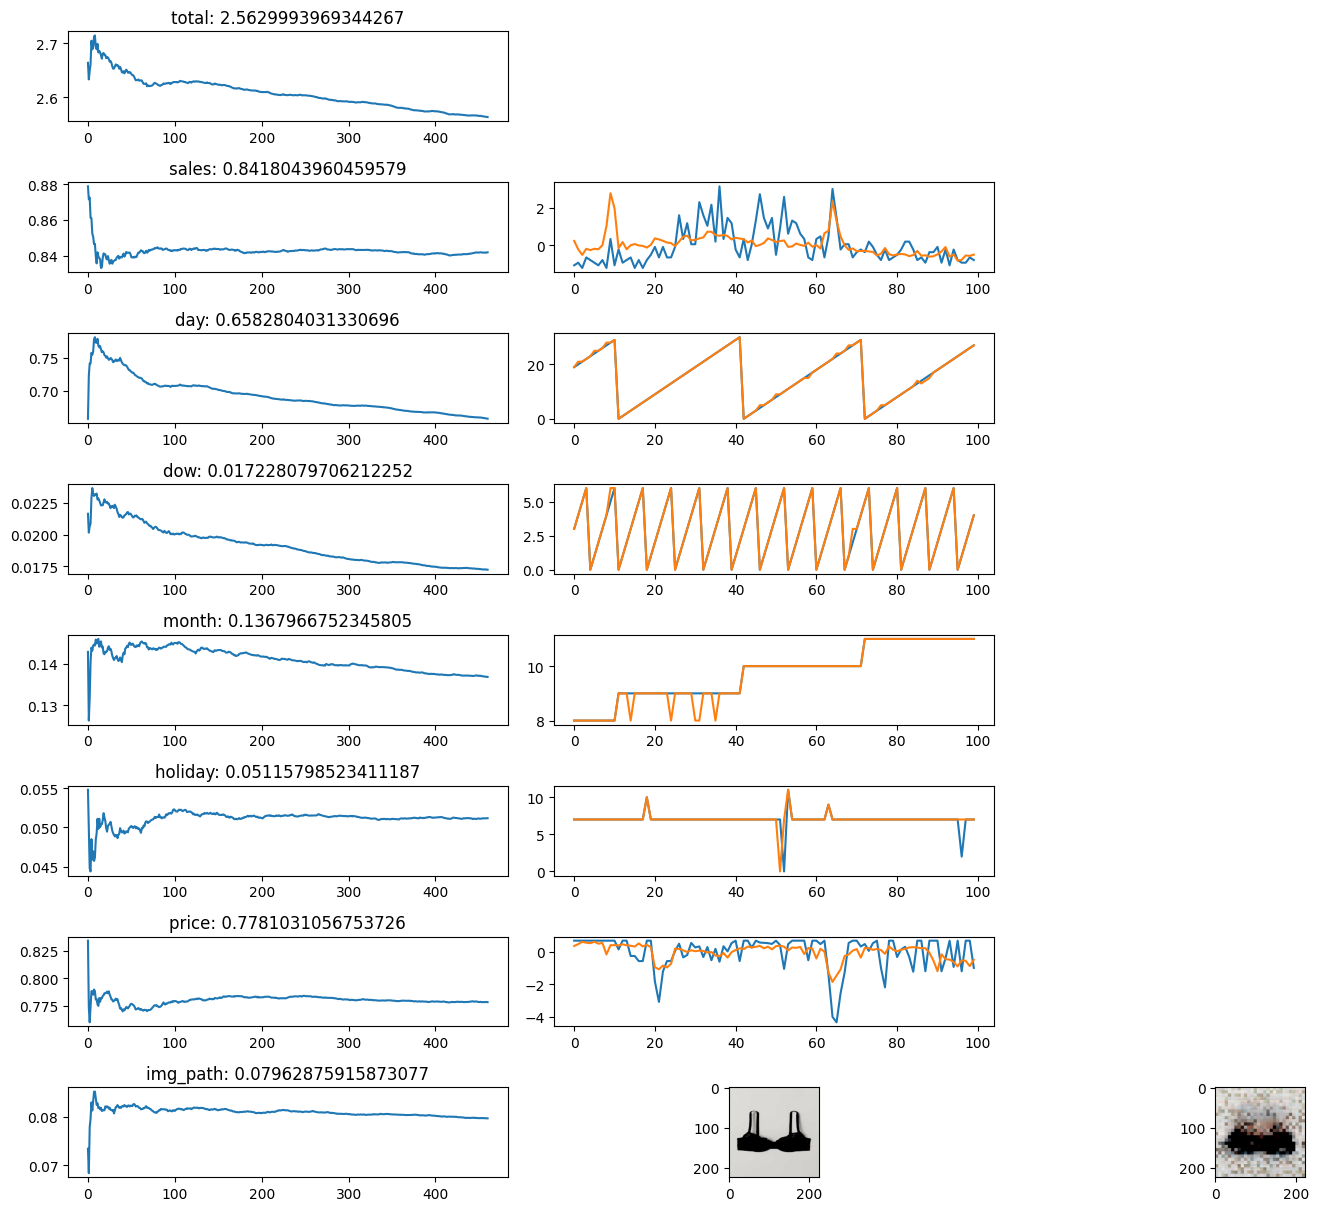

 51%|█████     | 468/915 [02:01<01:45,  4.25it/s]

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def get_loss(output_dict, data_dict, idx_dict, padding_mask_dict):
    loss_dict, pred_dict, y_dict = {}, {}, {}
    temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
    img_cols = data_info.modality_info["img"]
    nlp_cols = data_info.modality_info["nlp"]
    
    for n, ((key, pred), (_, y)) in enumerate(zip(output_dict.items(), data_dict.items())):
        assert key == _

        # Temporal
        if key in temporal_cols:
            if key in data_info.processing_info["scaling_cols"]:
                loss = mse_loss(pred.squeeze(), y.squeeze())
            elif key in data_info.processing_info["embedding_cols"]:
                loss = ce_loss(pred.view(-1, pred.shape[-1]), y.view(-1).to(torch.long))
                loss = loss.view(y.shape)
        elif key in img_cols:
            pred = pred[:, 1:, :]
            y = patchify(y, patch_size=patch_size)
            loss = mse_loss(pred, y)
        
        # Apply masks
        ### Temporal
        if key in temporal_cols:
            padding_mask = padding_mask_dict["temporal_padding_mask"]
            masked_mask = idx_dict["temporal_block_masked_idx"]
            masked_mask = (masked_mask==n).sum(dim=-1)
            total_mask = torch.where((padding_mask==1) & (masked_mask==1), 1, 0)

            loss *= total_mask
            loss = loss.sum() / total_mask.sum()
        
        ### Img
        elif key in img_cols:
            masked_mask = idx_dict[f"{key}_masked_idx"]
            loss = torch.gather(loss, index=masked_mask.unsqueeze(-1).repeat(1, 1, loss.shape[-1]), dim=1)
            loss = loss.mean()
        
        # Update dicts
        loss_dict[key] = loss
        if key in temporal_cols and key in data_info.processing_info["embedding_cols"]:
            pred = torch.argmax(pred, -1)
        elif key in img_cols:
            pred = unpatchify(pred, patch_size).permute(0,2,3,1)
            y = unpatchify(y, patch_size).permute(0,2,3,1)

        pred_dict[key] = pred
        y_dict[key] = y
    
    return loss_dict, pred_dict, y_dict

def update_dicts(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict):
    loss_li_dict["total"].append(total_loss.item())
    mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())

    for key, val in loss_dict.items():
        loss_li_dict[key].append(val.item())
        mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())

    return loss_li_dict, mean_loss_li_dict
    

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        output_dict, data_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)

        loss_dict, pred_dict, y_dict = get_loss(output_dict, data_dict, idx_dict, padding_mask_dict)
        total_loss = torch.stack(list(loss_dict.values())).sum()
        total_loss.backward()
        optimizer.step()

        # Update dicts
        loss_li_dict, mean_loss_li_dict = update_dicts(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict)

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 10, 3, 0
            plt.figure(figsize=(15, 15))
            clear_output(wait=True)

            # Plot sample loss
            plot_idx = 1
            for n, (key, val) in enumerate(mean_loss_li_dict.items()):
                # Individual loss
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(val)
                plt.title(f"{key}: {mean_loss_li_dict[key][-1]}")
                plot_idx += 1

                if key in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
                    plt.subplot(nrows, ncols, plot_idx)
                    plt.plot(y_dict[key].squeeze().detach().cpu()[idx])
                    plt.plot(pred_dict[key].squeeze().detach().cpu()[idx])
                elif key in data_info.modality_info["img"]:
                    plt.subplot(nrows, ncols, plot_idx)
                    plt.imshow(y_dict[key].detach().cpu()[idx])

                    plt.subplot(nrows, ncols, plot_idx+1)
                    plt.imshow(pred_dict[key].detach().cpu()[idx])
                    
                plot_idx += 2
                
            plt.tight_layout()
            plt.show()

epoch = 3
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise